<a href="https://colab.research.google.com/github/khs5696/AI504/blob/main/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
import torchvision.datasets as datasets
import torchvision.transforms as transforms

Hyperparameter

In [5]:
batch_size = 128
learning_rate = 0.0002
epochs = 200

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

Dataset

In [ ]:
dataset = datasets.MNIST(root='./', transform=transforms.ToTensor(), download=True)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=2)

100%|██████████| 9912422/9912422 [00:00<00:00, 137448546.51it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 88291322.03it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 53045739.99it/s]

Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 18247632.92it/s]

Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



Model

In [3]:
class Generator(nn.Module): # 100 -> 256 -> 256 -> 784
  def __init__(self):
    super(Generator, self).__init__()
    self.main = nn.Sequential(
      nn.Linear(100, 256),
      nn.ReLU(),
      nn.Linear(256, 256),
      nn.ReLU(),
      nn.Linear(256, 784),
      nn.Sigmoid(),
    )

  def forward(self, x):   # x : (batch_size, 100) -> (batch_size, 1, 28, 28)
    output = self.main(x)
    batch_size = output.size(0)
    output = output.view(batch_size, 1, 28, 28)
    return output



class Discriminator(nn.Module): # 784 -> 256 -> 256 -> 1
  def __init__(self):
    super(Discriminator, self).__init__()
    self.main = nn.Sequential(
      nn.Linear(784, 256),
      nn.LeakyReLU(0.2),
      nn.Linear(256, 256),
      nn.LeakyReLU(0.2),
      nn.Linear(256, 1),
      nn.Sigmoid(),
    )

  def forward(self, x):   # x : (batch_size, 1, 28, 28) -> (batch_size)
    batch_size = x.size(0)
    x = x.view(batch_size, 28*28)
    output = self.main(x)
    output = output.squeeze(dim=1)  # [128]
    return output

In [ ]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

optimizerG = torch.optim.Adam(generator.parameters(), lr=learning_rate)
optimizerD = torch.optim.Adam(discriminator.parameters(), lr=learning_rate)

loss = nn.BCELoss()

Train

In [ ]:
fixed_noise = torch.randn(batch_size, 100).to(device)

In [7]:
import numpy as np
import imageio
from google.colab import drive
from torchvision.utils import make_grid

drive.mount('/content/drive')

def save_gif(training_progress_images, images):
  img_grid = make_grid(images.data)
  img_grid = np.transpose(img_grid.detach().cpu().numpy(), (1, 2, 0))
  img_grid = 255. * img_grid
  img_grid = img_grid.astype(np.uint8)
  training_progress_images.append(img_grid)
  imageio.mimsave('/content/drive/MyDrive/연구/gan/img/training_progress.gif', training_progress_images)
  return training_progress_images

Mounted at /content/drive


In [ ]:
fixed_noise = torch.randn(128, 100).to(device)

def train(generator, discriminator, optimizerG, optimizerD, criterion):
  # generator.train()
  # discriminator.train()
  generator_loss_history = []
  discriminator_loss_history = []
  training_progress_images_list = []

  for epoch in range(epochs):
    print("-"*10)
    print("Epoch {}/{}".format(epoch+1, epochs))

    for image, label in dataloader:
      # Differentiate Real Image
      optimizerD.zero_grad()
      real = image.to(device)
      batch_size = real.size(0)
      real_label = torch.ones((batch_size,)).to(device)
      result = discriminator(real)    # (batch_size, 1, 28, 28) -> (batch_size)
      loss_real = criterion(result, real_label)
      D_x = result.mean().item()

      # Generate and Differentiate Fake Image : (batch_size, 100) -> (batch_size, 1, 28, 28)
      noise = torch.randn((batch_size, 100)).to(device)
      fake = generator(noise)
      fake_label = torch.zeros((batch_size,)).to(device)
      result = discriminator(fake.detach())
      loss_fake = criterion(result, fake_label)
      D_G_z1 = result.mean().item()

      # Backpropagation discriminator
      loss_discriminator = loss_real + loss_fake
      loss_discriminator.backward()
      optimizerD.step()

      # Backpropagation generator
      optimizerG.zero_grad()
      train_label = torch.ones((batch_size,)).to(device)
      train_result = discriminator(fake)
      loss_generator = criterion(train_result, train_label)
      loss_generator.backward()
      optimizerG.step()
      D_G_z2 = train_result.mean().item()

    # save the output
    progress_image = generator(fixed_noise)
    training_progress_images_list = save_gif(training_progress_images_list, progress_image)  # Save fake image while training!

    generator_loss_history.append(loss_generator)
    discriminator_loss_history.append(loss_discriminator)
    print("discriminator_loss : {} | generator_loss : {}".format(loss_discriminator, loss_generator))

    # save the checkpoint
    torch.save(generator.state_dict(), '/content/drive/MyDrive/연구/gan/checkpoint/generator_{}.pth'.format(epoch))
    torch.save(discriminator.state_dict(), '/content/drive/MyDrive/연구/gan/checkpoint/discriminator_{}.pth'.format(epoch))

  return generator, discriminator, generator_loss_history, discriminator_loss_history

generator, discriminator, generator_history, discriminator_history = train(generator, discriminator, optimizerG, optimizerD, loss)

----------
Epoch 1/200
discriminator_loss : 0.01992526836693287 | generator_loss : 8.948610305786133
----------
Epoch 2/200
discriminator_loss : 0.0187335554510355 | generator_loss : 9.651930809020996
----------
Epoch 3/200
discriminator_loss : 0.0014635894913226366 | generator_loss : 8.620336532592773
----------
Epoch 4/200
discriminator_loss : 0.010429037734866142 | generator_loss : 9.001669883728027
----------
Epoch 5/200
discriminator_loss : 0.025267237797379494 | generator_loss : 8.170703887939453
----------
Epoch 6/200
discriminator_loss : 0.007259339094161987 | generator_loss : 11.400760650634766
----------
Epoch 7/200
discriminator_loss : 0.090200275182724 | generator_loss : 8.211009979248047
----------
Epoch 8/200
discriminator_loss : 0.005765994545072317 | generator_loss : 9.125078201293945
----------
Epoch 9/200
discriminator_loss : 0.10998674482107162 | generator_loss : 8.26826000213623
----------
Epoch 10/200
discriminator_loss : 0.034051425755023956 | generator_loss : 9.0

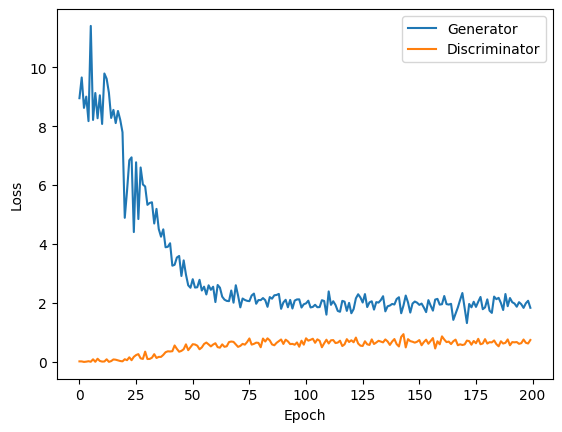

In [ ]:
import matplotlib.pyplot as plt

gloss = []
dloss = []

for gen in generator_history:
  gloss.append(gen.to('cpu').detach())

for dis in discriminator_history:
  dloss.append(dis.to('cpu').detach())

plt.plot(gloss)
plt.plot(dloss)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Generator', 'Discriminator'])
plt.show()

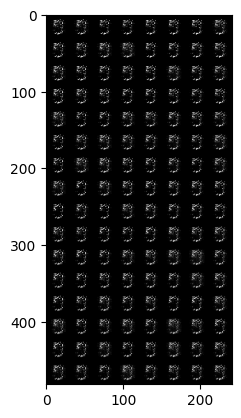

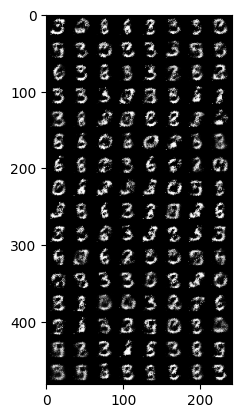

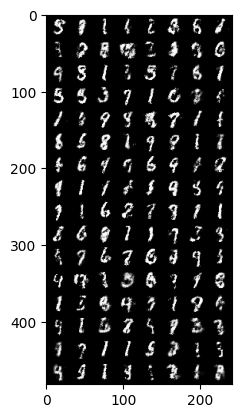

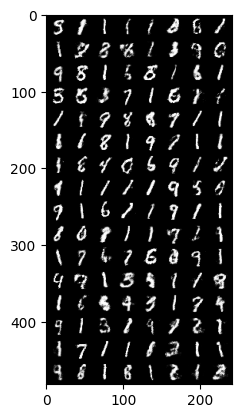

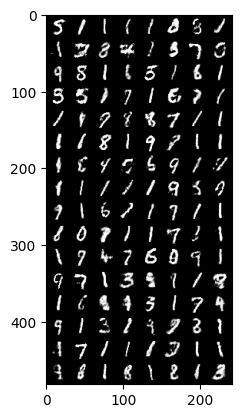

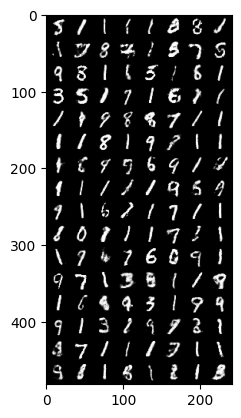

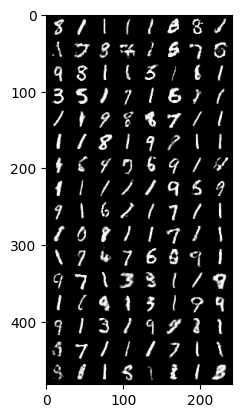

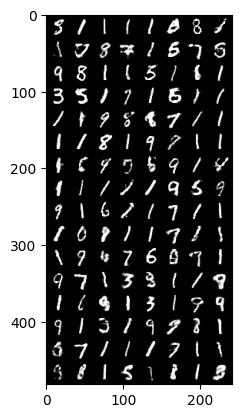

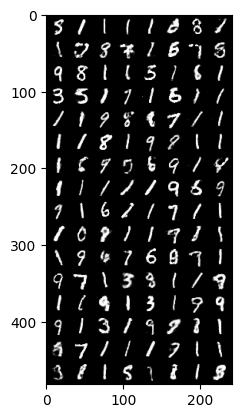

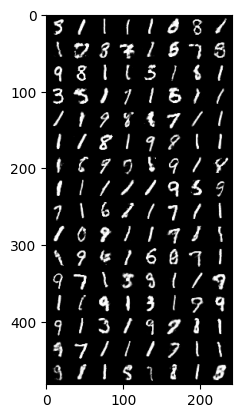

In [ ]:
from PIL import Image

gif_image = Image.open('/content/drive/MyDrive/연구/gan/img/training_progress.gif')

total_frame = gif_image.n_frames

for i in range(10):
  gif_image.seek(int(total_frame/10)*i)
  jpeg_image = gif_image.convert('RGB')

  plt.imshow(jpeg_image)
  plt.show()

  # jpeg_image.save(f'example_{frame_num:03d}.jpg')

Evaluation

In [13]:
import sys
import torchvision.utils as vutils

sys.path.append('/content/drive/MyDrive/연구/gan')

import inception
import fid_score
from fid_score import calculate_fid_given_paths

generator_eval = Generator().to(device)
generator_eval.load_state_dict(torch.load('/content/drive/MyDrive/연구/gan/checkpoint/generator_199.pth'))

# Real images
test = datasets.MNIST(root="./dataset", download=True, train=False, transform=transforms.ToTensor())
dataloader = torch.utils.data.DataLoader(test, batch_size=2048, shuffle=True, num_workers=2)

for i, (data, _) in enumerate(dataloader):
    # real_dataset = data
    for j in range(2048):
      vutils.save_image(data[j], '/content/drive/MyDrive/연구/gan/real/' + str(j+1) + '.png')
    break


# Fake images
noise = torch.randn(2048, 100).to(device)
fake_dataset = generator_eval(noise)

for i in range(2048):
  vutils.save_image(fake_dataset[i], '/content/drive/MyDrive/연구/gan/fake/' + str(i+1) + '.png')


# calculate_fid_given_paths(paths, batch_size, cuda, dims)
real_path = '/content/drive/MyDrive/연구/gan/real'
fake_path = '/content/drive/MyDrive/연구/gan/fake'
fid_value = calculate_fid_given_paths([real_path, fake_path], 50, True, 2048)

print (f'FID score: {fid_value}')

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)
100%|██████████| 82/82 [00:23<00:00,  3.49it/s]


FID score: 44.84662518887899


In [ ]:
# # !pip install pytorch-fid-wrapper
# import pytorch_fid_wrapper as pfw

# print(real_dataset.shape)
# print(fake_dataset.shape)

# pfw.set_config(batch_size=50, device='cuda:0')
# fid_score = pfw.fid(real_dataset, fake_dataset)
# print(fid_score)

torch.Size([50, 1, 28, 28])
torch.Size([50, 1, 28, 28])


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


RuntimeError: ignored